In [ ]:
# Import necessary libraries
import numpy as np
import os
import cv2  # For image processing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [ ]:
!pip install tensorflow

In [ ]:

# TensorFlow and Keras libraries for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Check if GPU is available
print(f"TensorFlow version: {tf.__version__}")
print("GPU Available: ", "Yes" if tf.config.list_physical_devices('GPU') else "No")





TensorFlow version: 2.18.0
GPU Available:  Yes


In [ ]:
pip install opencv-python

In [ ]:
# Set paths to your dataset
image_dir = '/content/drive/MyDrive/images'
mask_dir = '/content/drive/MyDrive/mask'


# List all image and mask files in the directories
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Sort the files to match images with their corresponding masks (ensure filenames match)
image_files.sort()
mask_files.sort()

# Preprocessing function for images
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalize the image
    return image

# Preprocessing function for masks (assuming masks are binary)
def preprocess_mask(mask_path, target_size=(256, 256)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_size)
    mask = np.expand_dims(mask, axis=-1)  # Add an extra dimension for the channels (1 for grayscale)
    mask = mask.astype('float32') / 255.0  # Normalize the mask
    return mask

# Load and preprocess images and masks
images = [preprocess_image(os.path.join('/content/drive/MyDrive/images', f)) for f in image_files]
masks = [preprocess_mask(os.path.join('/content/drive/MyDrive/mask', f)) for f in mask_files]

# Convert lists to numpy arrays
x_data = np.array(images)
y_data = np.array(masks)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

# Display the shape of the training and validation data
print(f"Training data shape: {x_train.shape}, Validation data shape: {x_val.shape}")


Training data shape: (680, 256, 256, 3), Validation data shape: (76, 256, 256, 3)


In [ ]:
# Performing binary classification (whole image):
y_train = np.array([1 if mask.sum() > 0 else 0 for mask in y_train])  # Create binary labels based on mask presence
y_val = np.array([1 if mask.sum() > 0 else 0 for mask in y_val])  # Same for validation

# Ensure the target is now binary with shape (None, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# Modify the output layer to predict a scalar value (0 or 1)
model = Sequential()

# CNN layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the CNN output
model.add(Flatten())

# LSTM layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))  # Single scalar output

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,811,201 (25.98 MB)

 Trainable params: 6,811,201 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.7567 - loss: 0.6401 - val_accuracy: 0.9605 - val_loss: 0.0666
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9790 - loss: 0.0776 - val_accuracy: 0.9474 - val_loss: 0.1034
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9819 - loss: 0.0472 - val_accuracy: 0.9605 - val_loss: 0.0813
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9783 - loss: 0.0588 - val_accuracy: 0.9868 - val_loss: 0.0398
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9968 - loss: 0.0164 - val_accuracy: 0.9868 - val_loss: 0.0239
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9921 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9848 - loss: 0.0261 - val_accuracy: 0.9868 - val_loss: 0.0266
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.9868 -

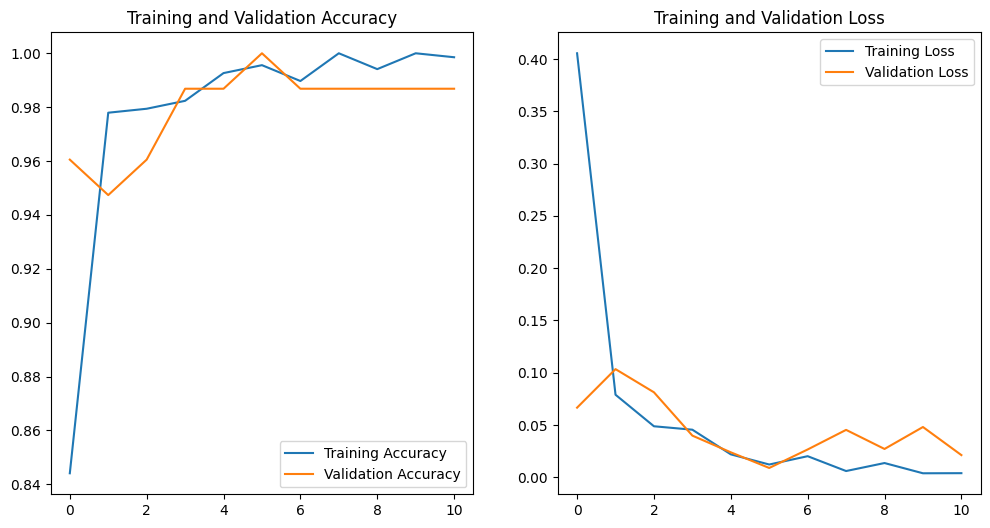

In [ ]:
# Define early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=16, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping])

# Plot the training and validation loss/accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        18

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



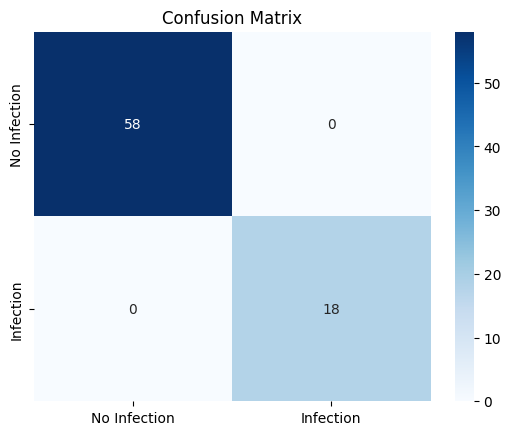

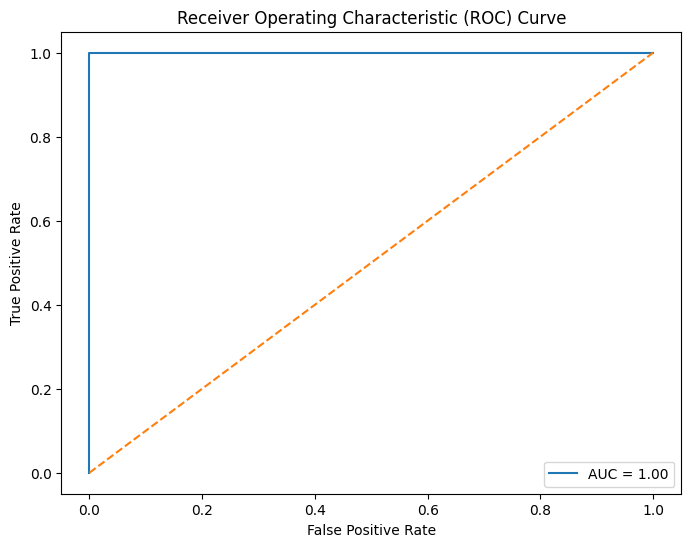

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary labels

# Classification report and confusion matrix
print(classification_report(y_val, y_pred))
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Infection', 'Infection'], yticklabels=['No Infection', 'Infection'])
plt.title('Confusion Matrix')
plt.show()

# AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


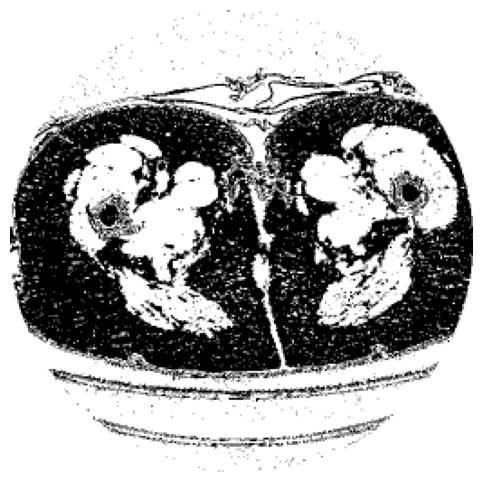

In [ ]:
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalize the image
    return image

# Example usage:
image_sample = preprocess_image('/content/drive/MyDrive/images/1.png')

# Show the processed image
plt.figure(figsize=(12, 6))
plt.imshow(image_sample)
plt.axis('off')
plt.show()


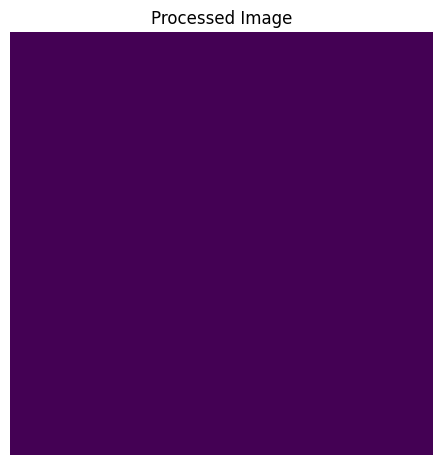

In [ ]:
# Use an existing image file, for example
mask_sample = preprocess_mask('/content/drive/MyDrive/mask/1.png')

# Show the processed image and mask
plt.figure(figsize=(12, 6))

# Display the image
plt.subplot(1, 2, 2)
plt.imshow(mask_sample)
plt.title("Processed Image")
plt.axis('off')
plt.show()


In [ ]:
# Save the trained model to disk
model.save('model.h5')
print("Model saved successfully!")


Model saved successfully!


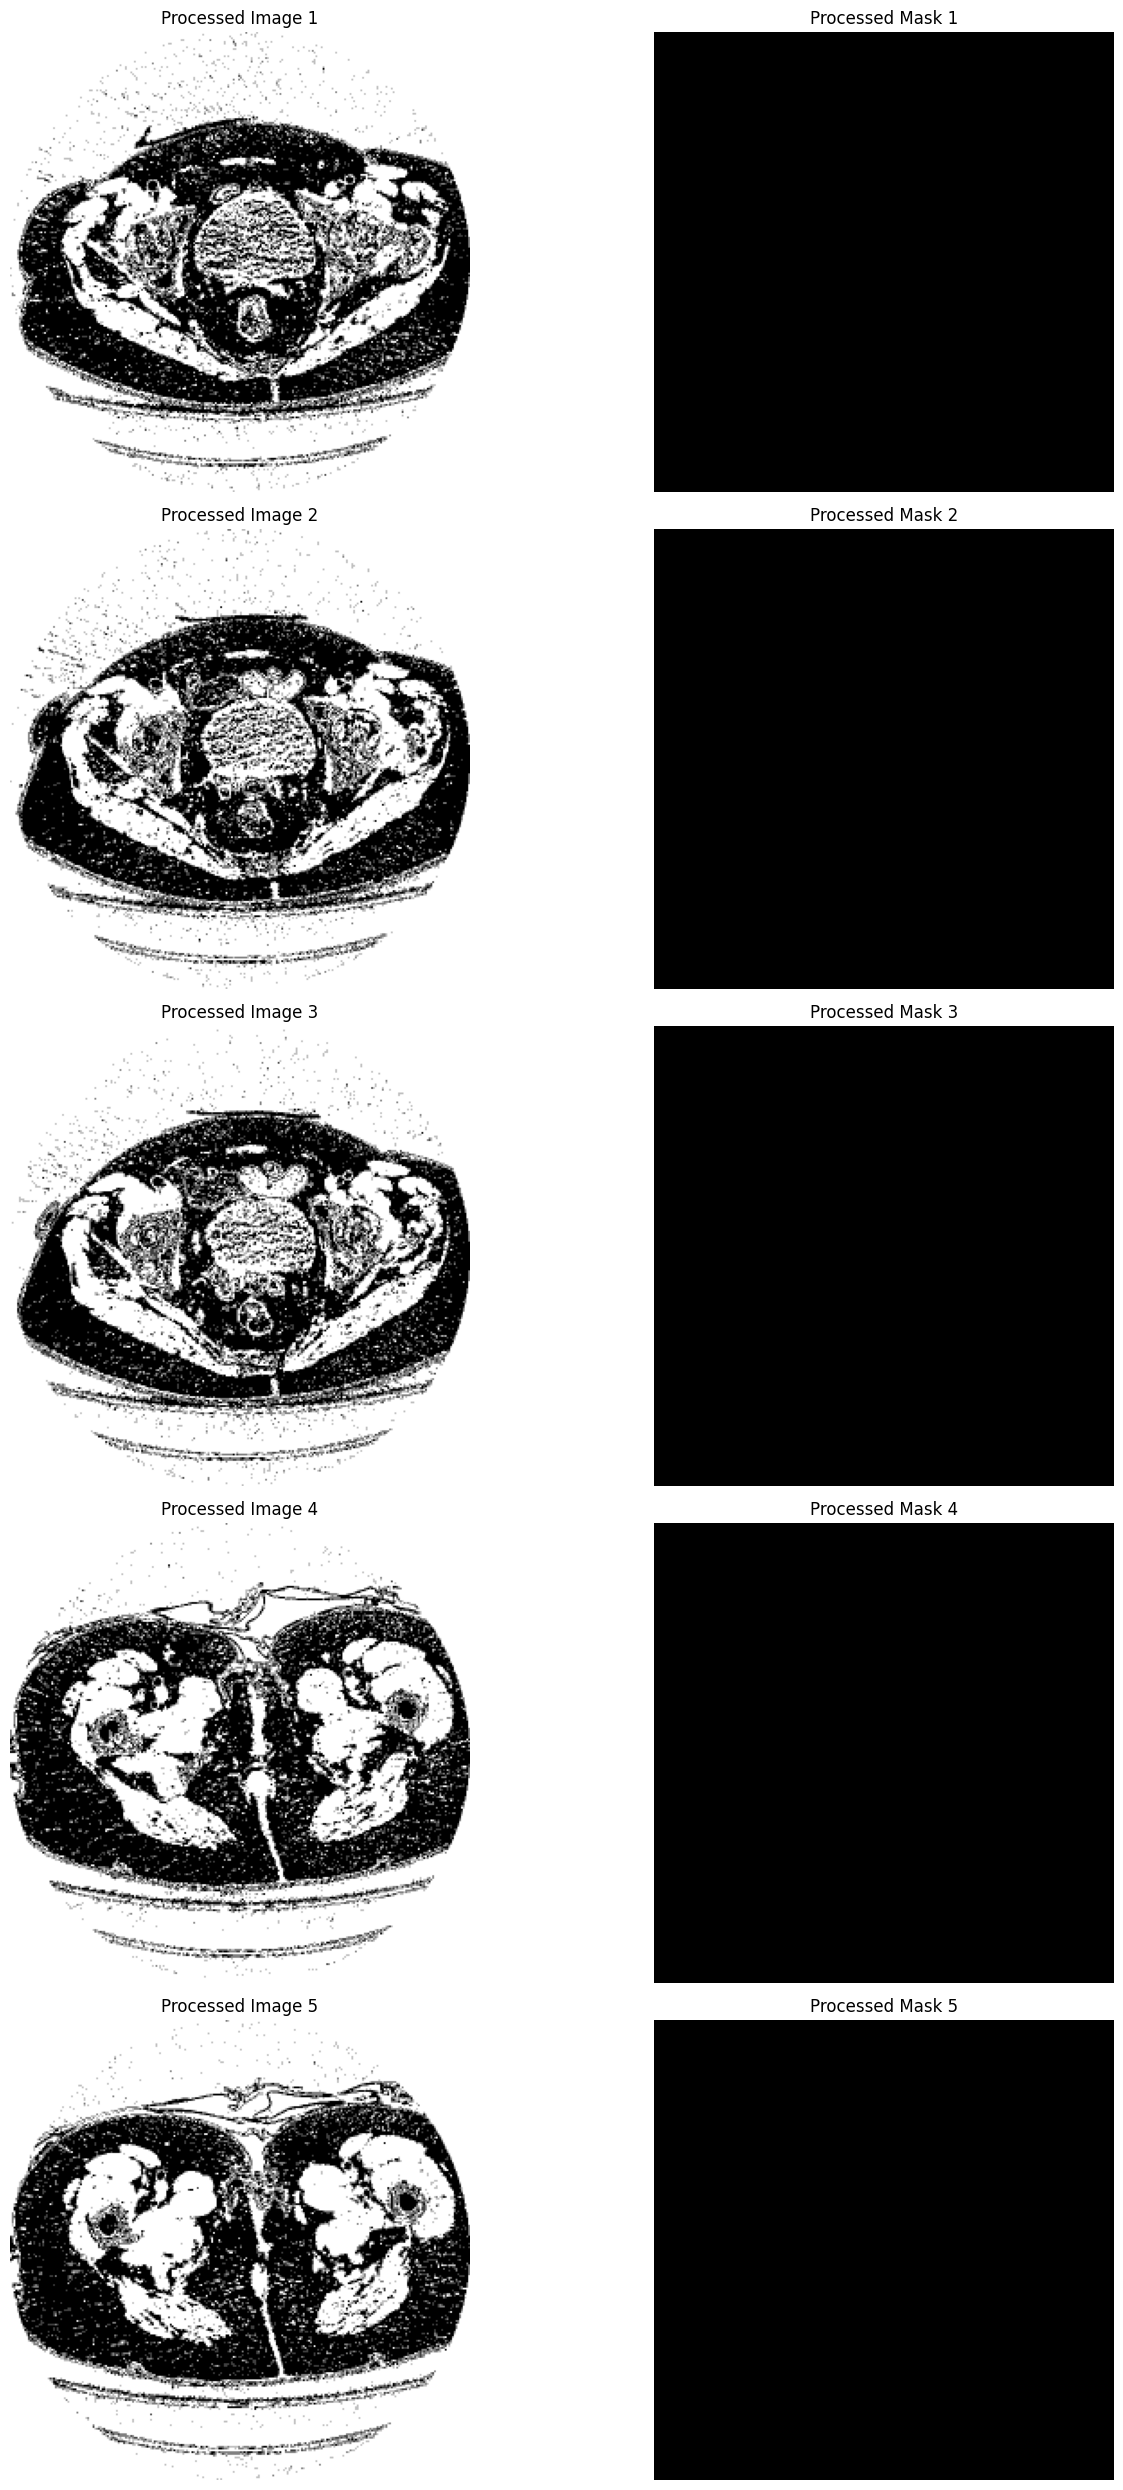

In [ ]:
import os
import matplotlib.pyplot as plt

# Define a function to load and preprocess a list of image-mask pairs
def display_multiple_images_and_masks(image_paths, mask_paths, num_images=5):
    plt.figure(figsize=(15, 5 * num_images))  # Adjust the figure size depending on how many images you want to display

    for i in range(num_images):
        # Load and preprocess each image and its corresponding mask
        image_sample = preprocess_image(image_paths[i])
        mask_sample = preprocess_mask(mask_paths[i])

        # Display the image
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(image_sample)
        plt.title(f"Processed Image {i+1}")
        plt.axis('off')

        # Display the mask
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(mask_sample, cmap='gray')
        plt.title(f"Processed Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Define the paths to your images and masks (ensure the masks directory path is correct)
image_dir = '/content/drive/MyDrive/images'
mask_dir = '/content/drive/MyDrive/mask'  # Ensure this is the correct path

# Get the first 5 images and masks (you can change this number)
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:5]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:5]

image_paths = [os.path.join(image_dir, f) for f in image_files]
mask_paths = [os.path.join(mask_dir, f) for f in mask_files]

# Call the function to display images and masks
display_multiple_images_and_masks(image_paths, mask_paths, num_images=5)


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('model.h5')  # Replace 'model.h5' with the actual path to your saved model

# Preprocessing function for images
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalize the image
    return image

# Function to predict infection status
def predict_infection(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)

    # Add batch dimension
    image = np.expand_dims(image, axis=0)

    # Make prediction
    prediction = model.predict(image)

    # Assuming the model outputs a probability (e.g., sigmoid output for binary classification)
    infection_probability = prediction[0][0]

    # Determine the class based on a threshold (e.g., 0.5)
    if infection_probability >= 0.5:
        return "Infected", infection_probability
    else:
        return "Not Infected", infection_probability

# Example usage
if __name__ == "__main__":
    image_path = '/content/drive/MyDrive/images/100.png'  # Replace with the path to your image
    try:
        status, probability = predict_infection(image_path)
        print(f"Status: {status}, Probability: {probability:.4f}")
    except ValueError as e:
        print(e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Status: Not Infected, Probability: 0.0000


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('model.h5')

# Preprocessing function for images
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalize the image
    return image

# Function to predict infection status
def predict_infection(image_path):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    infection_probability = prediction[0][0]
    if infection_probability >= 0.5:
        return "Infected", infection_probability
    else:
        return "Not Infected", infection_probability

# Define the paths to your images
image_dir = '/content/drive/MyDrive/images'

# Get the list of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Lists to store infected and non-infected image paths
infected_images = []
non_infected_images = []

# Iterate through images and predict infection status
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    try:
        status, _ = predict_infection(image_path)
        if status == "Infected":
            infected_images.append(image_path)
        else:
            non_infected_images.append(image_path)
    except ValueError as e:
        print(e)

# Ensure at least 5 images in each list
infected_images = infected_images[:5]
non_infected_images = non_infected_images[:5]

# Print the lists
print("Infected Images:")
for image_path in infected_images:
    print(image_path)

print("\nNon-Infected Images:")
for image_path in non_infected_images:
    print(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━